# Explorations around SPF

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install rioxarray
!pip install contextily
!pip install libpysal
!pip install geopandas
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 127.0 MB/s eta 0:00:00


In [ ]:
import sys
import os

# Replace 'path/to/your/directory' with the actual path where raster_utils.py is located.
# For example, if it's in a subfolder called 'my_modules' in the current directory:
# module_path = './my_modules'
# If it's in your Google Drive, you might have something like:
module_path = '/content/drive/MyDrive/DataProduct-SPF/demo/'

#module_path = './' # Assuming it's in the current directory if you used %%writefile

# Check if the path exists before adding it
if os.path.exists(module_path) and module_path not in sys.path:
    sys.path.insert(0, module_path)
    print(f"Added '{module_path}' to sys.path")
else:
    print(f"Path '{module_path}' already in sys.path or does not exist.")

# You can verify the path has been added (optional)
print(sys.path)

Path '/content/drive/MyDrive/DataProduct-SPF/demo/' already in sys.path or does not exist.
['/content/drive/MyDrive/DataProduct-SPF/demo/', '/content', '/env/python', '/usr/lib/python312.zip', '/usr/lib/python3.12', '/usr/lib/python3.12/lib-dynload', '', '/usr/local/lib/python3.12/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.12/dist-packages/IPython/extensions', '/root/.ipython']


In [ ]:
import pandas
import xarray
import rioxarray
import contextily as cx
import rasterio
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd

## Load up data

From Vitaly on [Teams](https://teams.microsoft.com/l/message/19:c5cfd4a0907c4d8e8101e39c2e2af420@thread.tacv2/1761584417355?tenantId=53255131-b129-4010-86e1-474bfd7e8076&groupId=a057e8ae-b090-42bd-bcf3-8afa3b45ea7f&parentMessageId=1761584417355&teamName=Imago-O365-Team&channelName=DataProduct-SPF&createdTime=1761584417355):

> [...] the first band is the simple mean annual cloud probability, and the second band shows the number of valid pixels used to calculate this probability [...]

In [ ]:
path_to_data = r'/content/drive/MyDrive/DataProduct-SPF/data_raw/OneDrive_1_11-11-2025/cloud_Newcastle_2024.tif'

In [ ]:
full_tiff = (
    rioxarray.open_rasterio(path_to_data, chunks=True)
    .compute()
)

- Cloud probability

In [ ]:
# We're going to make a bunch of plots, so here's something that makes plots.
def plot_sp(
    sp,
    ax=None,
    remove_axis=True,
    alpha=0.75,
    basemap_alpha=1,
    basemap_source=cx.providers.CartoDB.Positron,
    vmin=None,
    vmax=None,
    cmap=None,
    figsize=None,
    fig_width=10
):
    if ax is None:
        if figsize is None:
            # Calculate aspect ratio from raster bounds
            if hasattr(sp, 'rio') and hasattr(sp.rio, 'bounds'):
                bounds = sp.rio.bounds()
                width = bounds[2] - bounds[0]
                height = bounds[3] - bounds[1]
                aspect_ratio = width / height
            else:
                # Fallback to shape if rio not available
                height, width = sp.shape[-2:]
                aspect_ratio = width / height

            fig_height = fig_width / aspect_ratio
            figsize = (fig_width, fig_height)

        f, ax = plt.subplots(1, figsize=figsize)

    sp.plot.imshow(ax=ax, alpha=alpha, vmin=vmin, vmax=vmax, cmap=cmap)
    cx.add_basemap(ax, alpha=basemap_alpha, crs=sp.rio.crs, source=basemap_source, zorder=-1)

    if remove_axis:
        ax.set_axis_off()

    return ax

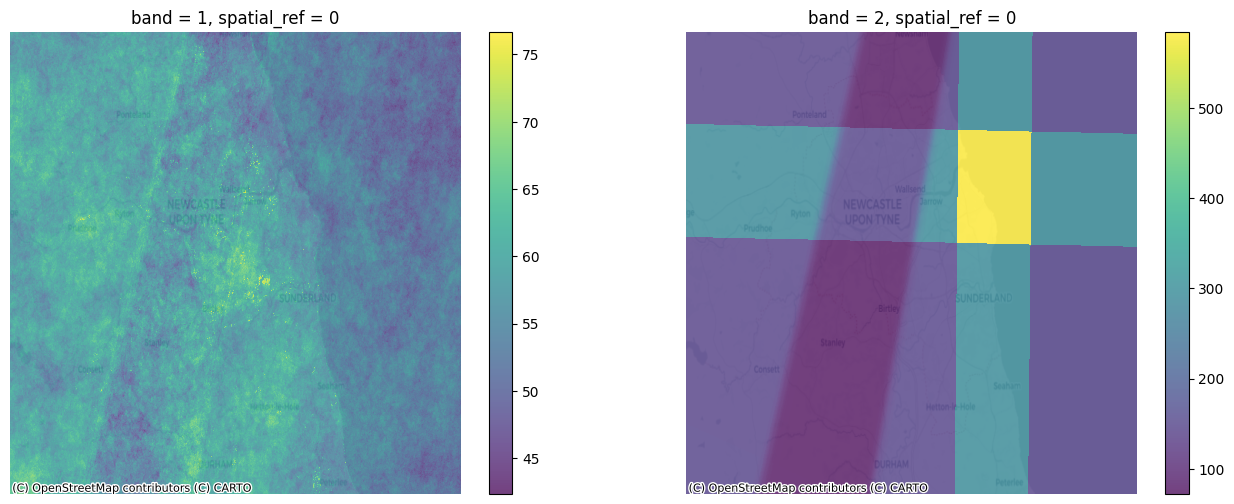

In [ ]:
f, axs = plt.subplots(1, 2, figsize=(16, 6))
minv, maxv = full_tiff.sel(band=1).min(), full_tiff.sel(band=1).max()

plot_sp(full_tiff.sel(band=1), ax=axs[0], vmin=minv, vmax=maxv)
plot_sp(full_tiff.sel(band=2), ax=axs[1])
plt.show()

## Correlation cloud prob. Vs # of acquisitions

In [ ]:
b1 = full_tiff.sel(band=1)
b2 = full_tiff.sel(band=2)
xarray.corr(b1, b2)

<xarray.DataArray ()> Size: 8B
array(-0.13276142)
Coordinates:
    spatial_ref  int64 8B 0

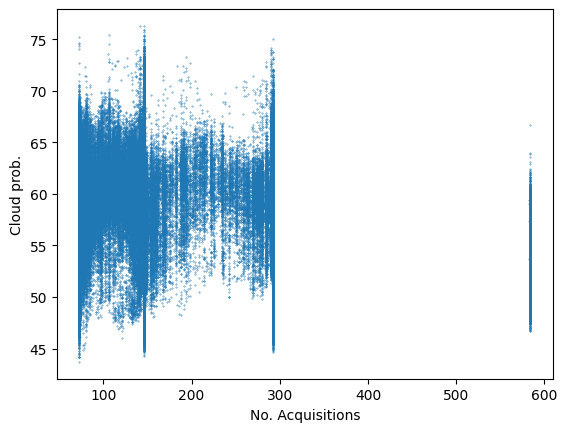

In [ ]:
(
    full_tiff
    .to_dataframe(name='value')
    ['value']
    .unstack('band')
    .sample(frac=0.2)
    .plot.scatter(
        2,
        1,
        s=0.1,
        xlabel='No. Acquisitions',
        ylabel='Cloud prob.'
    )
);

## Local divergence and Spatial Lag


- Build convolutions based smoothing
- Calculate difference between the two (in %)
- Map it

In [ ]:
from scipy.ndimage import convolve

def weighted_spatial_lag_conv(prob_array, acq_array, kernel_size=3):
    """
    Acquisition-weighted spatial lag using convolution.
    Matches: np.average(neighbor_probs, weights=neighbor_acqs)
    """
    prob = prob_array.values if hasattr(prob_array, 'values') else prob_array
    acq = acq_array.values if hasattr(acq_array, 'values') else acq_array

    # Create kernel (all neighbors, exclude center)
    kernel = np.ones((kernel_size, kernel_size))
    kernel[kernel_size // 2, kernel_size // 2] = 0

    # Handle NaNs - treat as 0 for convolution
    prob_filled = np.nan_to_num(prob, nan=0.0)
    acq_filled = np.nan_to_num(acq, nan=0.0)

    # Acquisition-weighted sum: Σ(prob_i * acq_i)
    weighted_prob_sum = convolve(prob_filled * acq_filled, kernel, mode='constant')

    # Sum of acquisition weights: Σ(acq_i)
    acq_sum = convolve(acq_filled, kernel, mode='constant')

    # Weighted average: Σ(prob_i * acq_i) / Σ(acq_i)
    weighted_lag = np.divide(
        weighted_prob_sum,
        acq_sum,
        where=acq_sum > 0,
        out=np.full_like(weighted_prob_sum, np.nan)
    )

    result = prob_array.copy(data=weighted_lag)
    return result

Applying the weighted spatial lag with a 21×21 kernel, meaning each pixel is influenced by up to 440 acquisition-weighted neighbors. At 20-meter resolution, that's a ~420-meter radius neighborhood.

In [ ]:
%%time
wy_convolved = weighted_spatial_lag_conv(
    full_tiff.sel(band=1),
    full_tiff.sel(band=2),
    kernel_size=21 # 21x21 window = 441 queen neighbors
)

CPU times: user 4.98 s, sys: 6.61 ms, total: 4.98 s
Wall time: 4.98 s


Then, we fit a linear model to clean up artefacts significantly different from their neighbours

In [ ]:
db = (
    full_tiff
    .to_dataframe('prob')
    [['prob']]
    .join((
        wy_convolved
        .to_dataframe('prob')
        [['prob']]
    ), lsuffix='_wy')
)
db['pct_diff'] = 100 * (db['prob'] - db['prob_wy']) / db['prob_wy']
db['pct_diff_masked'] = db['pct_diff'].median()

# Show both increases > 5% and decreases < -5%
db.loc[(db['pct_diff'] > 5) | (db['pct_diff'] < -5), 'pct_diff_masked'] = db.loc[(db['pct_diff'] > 5) | (db['pct_diff'] < -5), 'pct_diff']

db.head(3)

prob_wy       prob  pct_diff  pct_diff_masked
band y        x                                                        
1    540010.0 400010.0  65.267120  65.261017 -0.009352       -10.630796
              400030.0  64.732880  65.187019  0.701560       -10.630796
              400050.0  64.630135  65.135635  0.782144       -10.630796



*   Given that a pixel's cloud probability differs from its neighbors by `pct_diff_masked`, how much does that explain the original probability value?
*   The regression finds the linear relationship between neighborhood deviation and the pixel's actual value
* The residuals are what's left unexplained—the "idiosyncratic" part of each pixel




Each pixel gets shifted by (`median_prediction` - `its_individual_prediction`)

In [ ]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression().fit(db[['pct_diff_masked']], db['prob']) # Each location deviates from its acquisition-weighted neighbourhood
err = db['prob'] - lm.predict(db[['pct_diff_masked']])

In [ ]:
yb = lm.predict(
    pandas.DataFrame(
        db['pct_diff'].median(), index=db.index, columns=['pct_diff_masked']
    )
)

In [ ]:
clean_c = xarray.DataArray.from_series(yb + err)
clean_c = clean_c.rio.write_crs(full_tiff.rio.crs) # Give it a CRS from the original TIFF.

In [ ]:
lsoas = gpd.read_file(r'/content/drive/MyDrive/DataProduct-SPF/data_raw/uk_datazones.gpkg/uk_datazones.gpkg')

In [ ]:
# Clip LSOAs to raster extent using cx (coordinate indexer)
minx, miny, maxx, maxy = clean_c.rio.bounds()
lsoas_clipped = lsoas.cx[minx:maxx, miny:maxy]

<Axes: >

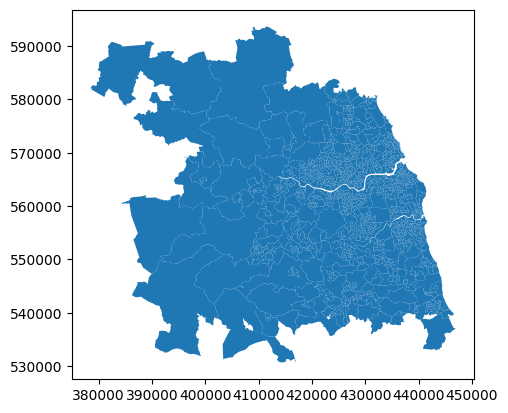

In [ ]:
lsoas_clipped.plot()

In [ ]:
!pip install exactextract

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 1.7 MB/s eta 0:00:00


Use exact_extract to compute statistics within each LSOA polygon, handling partial pixel overlaps using `exact_extract`'s innate area weighting

In [ ]:
# Run exact_extract on clipped LSOAs only
from exactextract import exact_extract

# Re-run exact_extract with LSOA identifiers (adjust column name as needed)
lsoa_id_col = 'LSOA21CD'


lsoa_stats = exact_extract(
    clean_c,
    lsoas_clipped,
    ['mean', 'median', 'min', 'max', 'stdev', 'count'],
    include_cols=[lsoa_id_col],  # Preserve the ID column
    output='pandas'
)

print(f"Stats shape: {lsoa_stats.shape}")
lsoa_stats.head()

# Join back to lsoas_clipped
lsoas_with_stats = lsoas_clipped.merge(lsoa_stats, on=lsoa_id_col, how='left')


/usr/local/lib/python3.12/dist-packages/osgeo/osr.py:410: FutureWarning: Neither osr.UseExceptions() nor osr.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Stats shape: (998, 13)


In [ ]:
lsoas_with_stats= lsoas_with_stats.rename(columns={
    'band_1_mean': 'probability_mean',
    'band_1_median': 'probability_median',
    'band_1_min': 'probability_min',
    'band_1_max': 'probability_max',
    'band_1_stdev': 'probability_stdev',
    'band_2_mean': 'acquisition_count_mean',
    'band_2_median': 'acquisition_count_median',
    'band_2_min': 'acquisition_count_min',
    'band_2_max': 'acquisition_count_max',
    'band_2_stdev': 'acquisition_count_stdev',
    ,
})

In [ ]:
lsoas_with_stats.drop(columns = ['acquisition_count_count','probability_count'], inplace = True)

In [ ]:
#lsoas_with_stats['geometry'] = lsoas_with_stats_filtered['geometry'].to_wkt()
lsoas_with_stats.to_csv('/content/drive/MyDrive/DataProduct-SPF/demo/data/SPF_cloud_prob_LSOA.csv', index=False)
lsoas_with_stats.to_file('/content/drive/MyDrive/DataProduct-SPF/demo/data/SPF_cloud_prob_LSOA.gpkg', index=False, driver= 'GPKG')